In [1]:
# Problem 3: Rapidly exploring Random Trees (RRT)
import numpy as np
from math import floor
import matplotlib.pyplot as plt
%matplotlib inline
import random as rnd
from mpl_toolkits.mplot3d import Axes3D
from copy import deepcopy

In [2]:
DURATION = 100
DELTA_T = 0.1

In [3]:
class MotionPlanner:

    def __init__(self, planner, objective, eps=0.5, delta=0.01, plot=False):
        # Planning
        self.planner = planner
        self.eps = eps        # linear distance tolerance
        self.delta = delta    # angular distance tolerance
        
        # State
        self.state = np.zeros((3, 1))
        self.state[:2, 0] = self.planner.initial[:, :2]
        self.u = np.zeros((2, 1))

        # Params
        self.delta_t = DELTA_T
        self.duration = DURATION
        self.K_v = 0.5
        self.K_w = 1.0
        self.l = 0.45
        self.objective = objective
        self.plot = plot

        # Plotting
        self.history = []
        self.history.append(self.state.T)
        self.ground_truth = []
        self.views = []

    
    def cmd_vel(self, v, w):
        """
        Simulate velocity input:
            v: linear velocity
            w: angular velocity
        """
        self.u[0] = v
        self.u[1] = w
    
    
    def lin_vel_ctrl(self, goal):
        """
        Linear velocity controller (P controller)
        """
        v = self.K_v * self.dist(goal, self.state[:2].T)
        return v
    
    
    def ang_vel_ctrl(self, goal):
        """
        Angular velocity controller (P controller)
        """
        w = self.K_w * (self.steering_angle(goal) - self.state[2, 0])
        return w

    
    def dist(self, x, y):
        """
        Distance metric (Euclidean)
        """
        return np.sqrt(-2 * np.dot(x, y.T) + np.sum(y**2, axis=1) + np.sum(x**2, axis=1)[:, np.newaxis])
    
    
    def ang_diff(self, theta1, theta2):
        """
        Returns the angular difference between the desired and current heading angle
        """
        diff = np.min((abs(theta1 - theta2), (2*np.pi - abs(theta1 - theta2))))
        return diff
    
    
    def steering_angle(self, goal):
        """
        Return required steering angle (radians)
        """
        return np.arctan2(goal[0, 1] - self.state[1], goal[0, 0] - self.state[0])
    


    def motion_model(self, state):
        new_state = np.zeros((3, 1))
        new_state[0, 0] = state[0, 0] + self.delta_t*self.u[0]*np.cos(state[2, 0])
        new_state[1, 0] = state[1, 0] + self.delta_t*self.u[0]*np.sin(state[2, 0])
        new_state[2, 0] = state[2, 0] + self.delta_t*self.u[1]
        return new_state

    
    def close_enough(self, t):
        dist = np.sqrt((self.goal[0]*0.1-self.state[0, 0])**2 + (self.goal[1]*0.1-self.state[1, 0])**2)
        return  dist < self.eps
    
    
    def plot_path(self, data, gt, scenic):
        """
        Plot robot position and orientation along scenic route
        """
        fig = plt.figure(figsize=(36, 12))
        plt.imshow(planner.grid, cmap=plt.cm.gray_r)
        n = len(data)
        # Ground truth plot
        ground = np.array(gt)
        plt.scatter(ground[:, 1], ground[:, 0], c='c', s=25)
        plt.plot(ground[:, 1], ground[:, 0], c='c', label="ground truth")
            
        # Actual
        for i in range(n):
            plt.scatter(data[i][0][1], data[i][0][0], s=20.25, color='r')
            plt.arrow(x=data[i][0][1],
                      y=data[i][0][0],
                      dx=2*np.cos(data[i][0][2]),
                      dy=2*np.sin(data[i][0][2]),
                      width=0.1,
                      head_width=0.8,
                      head_length=0.5,
                      color='r')
        # Scenic views
        s = len(scenic)
        for i in range(s):
            plt.scatter(scenic[i][0][1], scenic[i][0][0], s=20.25, color='g')
            plt.arrow(x=scenic[i][0][1],
                      y=scenic[i][0][0],
                      dx=2*np.cos(scenic[i][0][2]),
                      dy=2*np.sin(scenic[i][0][2]),
                      width=0.1,
                      head_width=0.8,
                      head_length=0.5,
                      color='g')
        plt.legend()
#         plt.title(title, fontsize=16)
#         plt.savefig('a2_results.png', dpi=300)
            
        

    # Waypoint navigation
    def run(self):
        waypoints = self.planner.path
        self.ground_truth += waypoints

        start = waypoints[0]
        finish = waypoints[-1]
        num_waypoints = len(waypoints)
        # Robot is already in starting position
        for j in range(1, num_waypoints):
            print("Waypoint {}: {}".format(j, waypoints[j]))
            goal = np.array([waypoints[j]])
            # Go-to-goal behaviour
            # NOTE: need to change goal (Y, X) --> (X, Y)
            dist = self.dist(goal[::-1], self.state[:2].T)
            old_dist = 0
            limit = None
            while self.dist(goal[::-1], self.state[:2].T) > self.eps:
                old_dist = dist
                dist = self.dist(goal[::-1], self.state[:2].T)
                # Prevent robot from diverging
                if dist > old_dist:
                    if limit is None:
                        limit = old_dist + 0.5

                # Update velocity commands
                if limit is not None and dist > limit:
                    print("Need to reposition robot (turn in place)")
                    heading = np.arctan2(goal[::-1][0, 1] - self.state[1], goal[::-1][0, 0] - self.state[0])
                    while self.ang_diff(heading[0], self.state[-1][0]) > self.delta:
                        v = 0
                        w = self.ang_vel_ctrl(goal[::-1])
                        self.cmd_vel(v, w)
                        self.state = self.motion_model(self.state)
                        limit = None
                else: 
                    v = self.lin_vel_ctrl(goal[::-1])
                    w = self.ang_vel_ctrl(goal[::-1])
                    self.cmd_vel(v, w)

                    # Update motion state
                    self.state = self.motion_model(self.state)

            # Waypoint reached
            print("Goal {} ({}) reached! ({})".format(j, self.state, waypoints[j]))
            self.history.append(self.state.T)

        # Turn-in-place behaviour
        print("Scenic point {} ({}) reached! ({})".format(self.objective, self.state, self.planner.waypoint))
        heading = self.planner.waypoint[0][-1]
        print("Desired heading: {}".format(heading))
        while self.ang_diff(heading, self.state[-1]) > self.delta:
            # Update velocity commands (constant turning angle)
            v = 0
            w = 0.5
            self.cmd_vel(v, w)

            # Update motion state
            self.state = self.motion_model(self.state)
        print("What a view at {}! ({})".format(self.state[2, 0], heading))
        self.views.append(self.state.T)
        print("So long Blockville!")

In [4]:
class Node:
    def __init__(self, index=None, parent=None, position=None):
        """
        Node class to represent various waypoints in roadmap
            index: index of node in samples
            parent: parent node in tree
            child: child node if any (added to help with traversal)
            position: Y, X coordinates in configuration space (shape: (2, 1))
        Fields:
            g: distance to seed
            h: distance to goal (heuristic)
            f: weight of node (sorting index) --> f = g + h
        """
        self.index = index
        self.parent = parent
        self.child = None
        self.position = position
        self.g = 0
        self.h = 0
        self.f = 0
    
    
    def __eq__(self, other):
        return (self.position == other.position).all()
    
    def __lt__(self, other):
        return self.f < other.f
    
    def __le__(self, other):
        return self.f <= other.f
    
    def __gt__(self, other):
        return self.f > other.f
    
    def __ge__(self, other):
        return self.f >= other.f

In [5]:
class RandomTree:
    def __init__(self, seed, goal):
        """
        Undirected graph G=(V, E) representing potential roadmaps in the configuration space
        """
        # Add seed as first vertex and root of tree
        self.V = []
        self.V.append(Node(parent=None, index=0, position=np.array(seed)))

        
        self.points = np.array(seed) # 2D array of (Y, X) points
        self.n = self.points.shape[0]
        self.G = np.zeros((self.n, self.n))
        self.goal = goal
   

    def __len__(self):
        return len(self.V)
    
    
    def __getitem__(self, index):
        # Returns a Node object
        return self.V[index]
    
    
    def __repr__(self):
        return str(self.unwrap())
    
    
    def unwrap(self, index=None):
        """
        Unwrap tree from leaf to root
            index: index of a specific leaf
        """
        # Identify leaf nodes
        tree = []
        if index is not None:
            leaves = [self.V[index]]
        else:
            leaves = list(filter(lambda x: (x.child is None), self.V))
            print("Leaves: {} vs Tree length: {}".format(len(leaves), len(self.V)))
        for leaf in leaves:
            path = []
            current = leaf
            while current.parent is not None:
                path.append(current.position[0])
                current = current.parent
            path.append(current.position[0])
            path.reverse()
            tree.append(path)
        return tree

    
    def add(self, node):
        """
        Add a node to the random tree
        """
        # Update the parent's child to be the current node
        node.parent.child = node
        self.V.append(node)
        self.points = np.append(self.points, node.position, axis=0)
       
    
    def closest(self, new_point):
        """
        Find node in the tree closest to point
        """
        d = self.dist(self.points, new_point)
        closest = np.argmin(d)
        return self.V[closest], d[closest][0]


    def dist(self, x, y):
        """
        Distance metric (L2 norm)
        """
        return np.sqrt(-2 * np.dot(x, y.T) + np.sum(y**2, axis=1) + np.sum(x**2, axis=1)[:, np.newaxis])


In [6]:
class RRTPlanner:

    def __init__(self, grid, delta=1.0, eps=0.0, N=500, plot=False):
        """
        Rapidly expanding random trees path planner
            N: number of sampling iterations
            delta: step size used to grow the tree at each iteration
            eps: Epsilon greedy probability to guide the sampling of q_rand;
                 in this case, set q_rand = q_goal with probability p(eps)
        """
        # Map characteristics
        self.grid = grid
        self.obstacles = self.pre_process(deepcopy(grid)) # to check if sample is an obstacle: (sample == obstacles).all(1).any()
        self.plot = plot
        
        # Parameters
        self.delta = delta
        self.eps = eps
        self.num_iter = N
        
        # Path building
        self.initial = None
        self.waypoint = None
        self.sample = None
        self.total_path = [] # sum of paths
        self.path = []       # most recent path

        
    def pre_process(self, grid):
        """
        Modify environment to meet planning constraints
        Returns the obstacles found in the environment
        """
        # Add 3px buffer space around obstacles to account for robot baseline (b/2 = 0.45m -> 5/2px -> 3px)
        buffer = 3
        dist = 1
        y_end, x_end = grid.shape
        for j in range(buffer):
            closest_y, closest_x = np.where(grid==1)
            num = closest_x.shape[0]
            for i in range(num):
                grid[max(closest_y[i]-1,0):min(closest_y[i]+2,y_end), max(closest_x[i]-1,0):min(closest_x[i]+2,x_end)] = np.where(grid[max(closest_y[i]-1,0):min(closest_y[i]+2,y_end), max(closest_x[i]-1,0):min(closest_x[i]+2,x_end)] == 0, 
                                                                                                                                  1,
                                                                                                                                  grid[max(closest_y[i]-1,0):min(closest_y[i]+2,y_end), max(closest_x[i]-1,0):min(closest_x[i]+2,x_end)])

        obstacles = np.argwhere(grid==1)
        return obstacles
 

    def extend(self, q_near, q_rand, dist):
        """
        Extend q_near in the direction q_near->q_rand
        """
        q_new = np.zeros_like(q_near)
        angle = np.arctan2(q_rand[0, 0] - q_near[0, 0], q_rand[0, 1] - q_near[0, 1])
        q_new[0, 0] = q_near[0, 0] + self.delta*np.sin(angle)
        q_new[0, 1] = q_near[0, 1] + self.delta*np.cos(angle)
        new_dist = self.dist(q_new, q_near)[0][0]
        return q_new, new_dist
        
    
    def grow_tree(self, treeA, treeB):
        """
        Grow tree by attempting to append q_rand (randomly sampled from q_free) to the tree
        Attempt to join current tree to concurrent tree and return leaf of joining path
        """
        leaf_A = None
        leaf_B = None
        p = np.random.randn()
        if p < self.eps: # epsilon greedy
            q_rand = treeB.goal
        else:
            q_rand = np.random.randint(self.grid.shape[0], size=(1, 2))

        q_latest = None
        if not (q_rand == self.obstacles).all(1).any():
            # Find node closest to q_rand
            n_near, dist = treeA.closest(q_rand)

            if dist <= self.delta and not self.collision(n_near.position, q_rand):
                treeA.add(Node(parent=n_near, index=len(treeA) + 1, position=q_rand))
                q_latest = q_rand

            elif dist > self.delta:
                # Move q_near closer to q_rand by a distance delta
                q_new, new_dist = self.extend(n_near.position, q_rand, dist)
                
                # Check for collisions
                if not self.collision(n_near.position, q_new):
                    treeA.add(Node(parent=n_near, index=len(treeA) + 1, position=q_new))
                    q_latest = q_new
        
        # Attempt to merge trees
        if q_latest is not None:
            # Find the closest node in the concurrent tree to the one just added
            nearest, distance = treeB.closest(q_latest)
            if not self.collision(nearest.position, q_latest):
                leaf = nearest.position
                print("Trees merged at: {}, {}".format(leaf, q_latest))
                # Add final node to close path
                latest = treeA[-1]
                treeA.add(Node(parent=latest, index=len(treeA) + 1, position=nearest.position))
                leaf_A = latest.index
                leaf_B = nearest.index
        # Return child of node added before last
        return leaf_A, leaf_B
            
                  
            
    def find_path(self, start, goal):
        """
        Find path connecting path by growing a random tree from the start and goal
        Returns a list of waypoints if successful (i.e., complete path)
        """
        # Initialize trees with seeds q_start and q_goal
        self.initial = np.array([start])
        q_start = self.initial[:, :2]
        self.waypoint = np.array([goal])
        q_goal = self.waypoint[:, :2]
        
        atree = RandomTree(q_start, q_goal)
        btree = RandomTree(q_goal, q_start)
        
        trees_merged = False
        for i in range(self.num_iter):
            # Grow tree from start node to goal node
            index_A, index_B = self.grow_tree(atree, btree)
            if index_A is not None and index_B is not None:
                index_B -= 1
                trees_merged = True
                break
            # Grow tree from goal node to start node
            index_B, index_A = self.grow_tree(btree, atree)
            if index_B is not None and index_A is not None:
                index_A -= 1
                trees_merged = True
                break
        
        if i == self.num_iter:
            print("Max number of iterations exceeded!")
        
        # Path unwrapping
        path = []
        if trees_merged:
            path_A = atree.unwrap(index=index_A)
            path_B = btree.unwrap(index=index_B)
            path = path_A[0] + path_B[0][::-1][1:]

        # Whole tree unwrapping
        tree_A = atree.unwrap()
        tree_B = btree.unwrap()
        tree_sequence = [tree_A, tree_B]
        title = "treeA("+ str(tree_A[0][0]) + ")<->treeB(" + str(tree_B[0][0]) + ")"
        self.plot_grid(grid=self.grid, points=tree_sequence, title=title, mode=4)
        
        if path:
            self.path = path
            self.total_path.append(path)
            title = "start(" + str(path[0]) + ")_to_goal(" + str(path[-1]) + ")"
            self.plot_grid(grid=self.grid, path=self.total_path, title=title, mode=3)
         

    def collision(self, start, end):
        """
        Check for collisions between two samples of q_free based on the intersection
        of Bresenham line coordinates and the known obstacle coordinates
        
        Returns true if there are no collision between start and end
        """
        line = self.bresenham(start, end)
        collision = np.array([(line[j]==self.obstacles).all(1).any() for j in range(line.shape[0])]).any()
        return collision

    
    def dist(self, x, y):
        """
        Distance metric (L2 norm)
        """
        return np.sqrt(-2 * np.dot(x, y.T) + np.sum(y**2, axis=1) + np.sum(x**2, axis=1)[:, np.newaxis])
   

    def bresenham(self, start, end):
        """
        Bresenham line algorithm (source: MTE-544 course content)
            x1, y1: start position (shape: (2, 1))
            x2, y2: end position (shape: (2, 1))
            output: line coordinates from (x1, y1) to (x2, y2) (shape: (x, 2))
        """
        x1 = round(start[0, 0])
        x2 = round(end[0, 0])
        y1 = round(start[0, 1])
        y2 = round(end[0, 1])

        dx = abs(x2 - x1)
        dy = abs(y2 - y1)

        steep = dy > dx
        if steep:
            t = dx
            dx = dy
            dy = t

        if dy == 0:
            q = np.zeros([int(dx + 1), 1])
        else:
            q = [a for a in np.arange(floor(dx / 2), -dy * dx + floor(dx / 2) - dy, -dy)]
            q = np.hstack([0, (np.diff(np.mod(q, dx)) >= 0).astype(float)])

        if steep:
            if y1 <= y2:
                y = np.arange(y1, y2 + 1)
            else:
                y = np.arange(y1, y2 - 1, -1)
            if x1 <= x2:
                x = x1 + np.cumsum(q)
            else:
                x = x1 - np.cumsum(q)
        else:
            if x1 <= x2:
                x = np.arange(x1, x2 + 1)
            else:
                x = np.arange(x1, x2 - 1, -1)
            if y1 <= y2:
                y = y1 + np.cumsum(q)
            else:
                y = y1 - np.cumsum(q)
        return np.concatenate((np.array([x]).T, np.array([y]).T), axis=1)

    
    def plot_grid(self, grid=None, points=None, path=None, title="title", mode=-1):
        """
        Helper function to plot various grid types
        """
        if self.plot:
            fig = plt.figure(figsize=(24, 12))
            plt.imshow(grid, cmap=plt.cm.gray_r)
            if mode == 3: # plotting path(s)
                # REQUIRES: grid, path
                plt.scatter(path[0][0][1], path[0][0][0], marker='s', color='black', s=100)
                plt.scatter(path[-1][-1][1], path[-1][-1][0], marker='s', color='black', s=100)
                num_paths = len(path)
                colours = ['bo-', 'go-', 'mo-', 'yo-']
                for i in range(num_paths):
                    cpath = path[i]
                    num_points = len(cpath)
                    for p in range(0, num_points-1, 1):
                        x = [cpath[p][1], cpath[p+1][1]]
                        y = [cpath[p][0], cpath[p+1][0]]
                        plt.plot(x, y, colours[i])
                    
#                     plt.scatter(points[:, 1], points[:, 0], c="r", s=10)
            elif mode == 4: # plotting both start and goal trees
                # REQUIRES: grid, points
                trees = len(points)
                marking = ['ro-', 'co-']
                for t in range(trees):
                    paths = len(points[t])
                    plt.scatter(points[t][0][0][1], points[t][0][0][0], marker='s', color='black', s=100)
                    for p in range(paths):
                        n = len(points[t][p])
                        for i in range(0, n-1, 1):
                            x = [points[t][p][i][1], points[t][p][i+1][1]]
                            y = [points[t][p][i][0], points[t][p][i+1][0]]
                            plt.plot(x, y, marking[t])
                        
                # Overlay start and waypoints in different color
#                 plt.scatter(points[:5, 1], points[:5, 0], marker="v", c="g", s=500)
                
                # Overlay path segment if available
                if path:
                    n = len(path)
                    for i in range(n):
                        plt.plot(path[i][0, 1], path[i][0, 0], 'bo-')
                
            else:
                print("Plotting mode not recognized!")

            plt.title(title, fontsize=16)
#             plt.show()

In [7]:
# Utils
def read_pgm(pgmf):
    """
    Read pgm map as numpy array
    """
    with open( pgmf, 'rb' ) as f:
        #Return a raster of integers from a PGM as a list of lists
        header =  f.readline()
        # print( header[0], header[1] )
        assert header == b'P5\n'
        while True:
            l = f.readline()
            if not l[0] == 35:   # skip any header comment lines
                break
        (width, height) = [int(i) for i in l.split()]
        depth = int(f.readline())
        assert depth <= 255

        raster = []
        for y in range(height):
            row = []
            for y in range(width):
                row.append(ord(f.read(1)))
            raster.append(row)
    return np.array(raster)

Iteration 0
Trees merged at: [[80 73]], [[62 65]]
Leaves: 178 vs Tree length: 197
Leaves: 169 vs Tree length: 180
Waypoint 1: [11  7]
Goal 1 ([[10.61902115]
 [ 6.7137821 ]
 [ 0.61754618]]) reached! ([11  7])
Waypoint 2: [28 22]
Goal 2 ([[27.66679731]
 [21.63308858]
 [ 0.8307852 ]]) reached! ([28 22])
Waypoint 3: [49 15]
Goal 3 ([[48.89419731]
 [15.46967283]
 [-1.32961934]]) reached! ([49 15])
Waypoint 4: [59 17]
Goal 4 ([[58.90515405]
 [16.52760382]
 [ 1.32982862]]) reached! ([59 17])
Waypoint 5: [88 13]
Goal 5 ([[87.89700892]
 [13.4774335 ]
 [-1.34233734]]) reached! ([88 13])
Waypoint 6: [89 34]
Need to reposition robot (turn in place)
Goal 6 ([[88.9855262 ]
 [33.51623787]
 [ 1.54061805]]) reached! ([89 34])
Waypoint 7: [92 63]
Goal 7 ([[91.91229966]
 [62.51768123]
 [ 1.39240754]]) reached! ([92 63])
Waypoint 8: [91 84]
Goal 8 ([[91.13515863]
 [83.52888067]
 [ 1.84412663]]) reached! ([91 84])
Waypoint 9: [82 83]
Need to reposition robot (turn in place)
Goal 9 ([[82.47651304]
 [83.0929

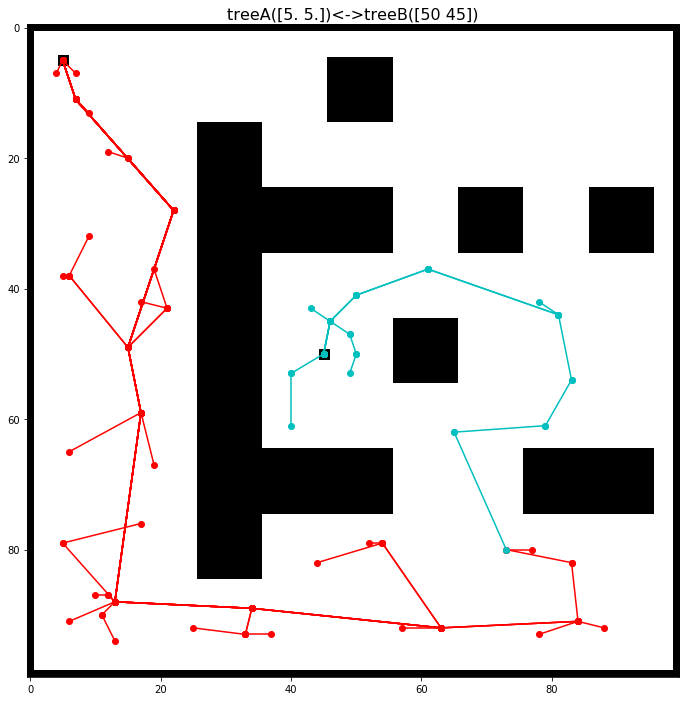

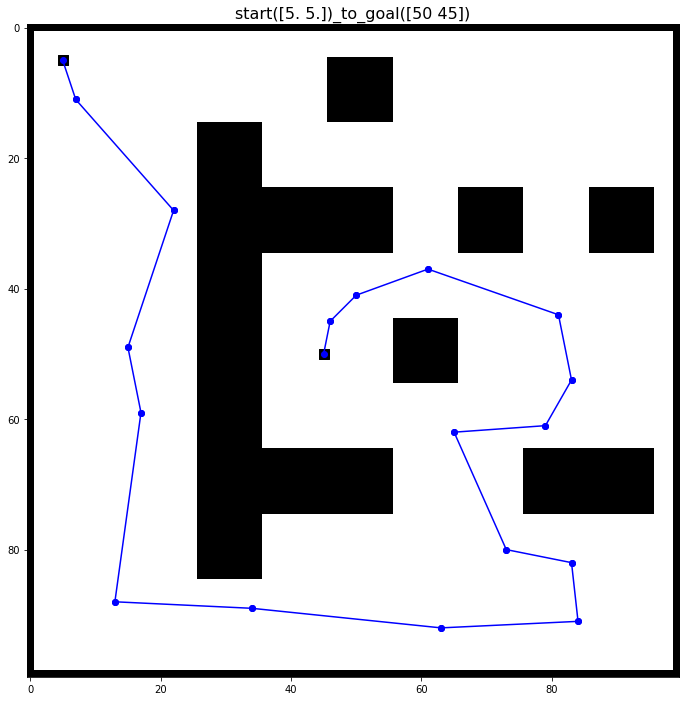

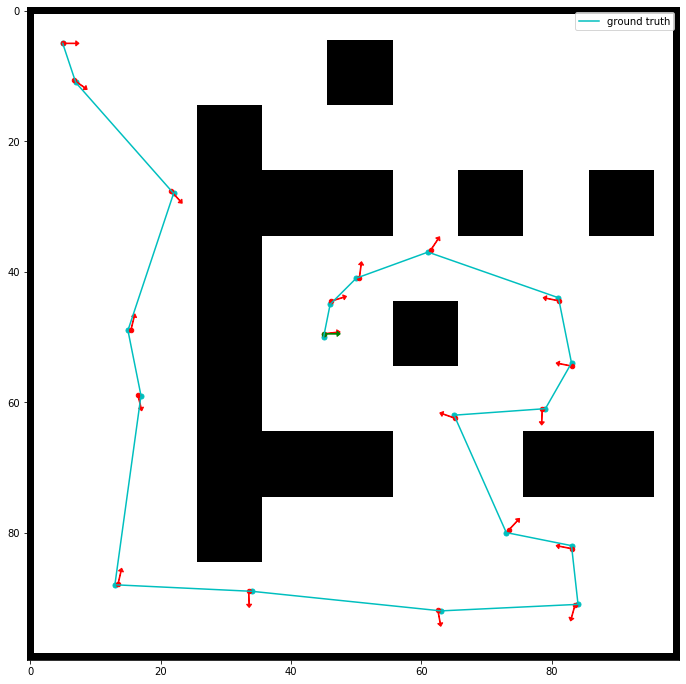

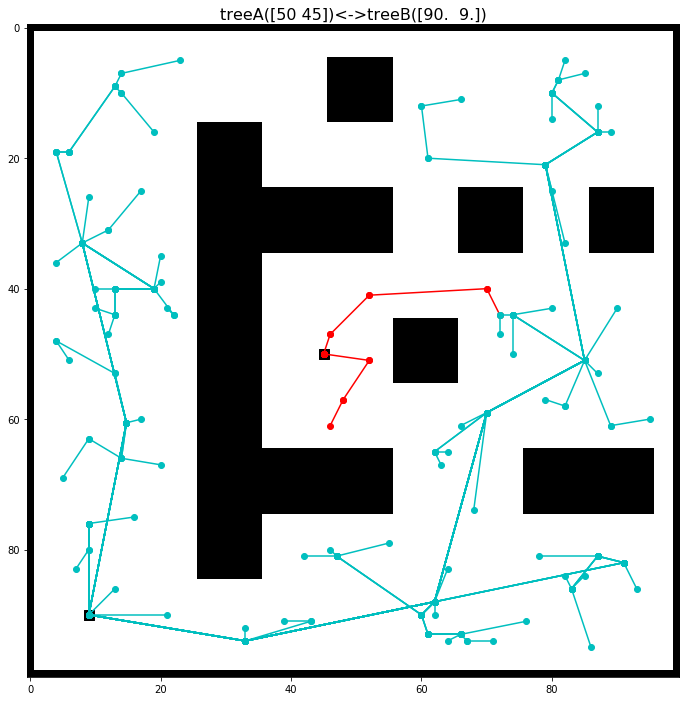

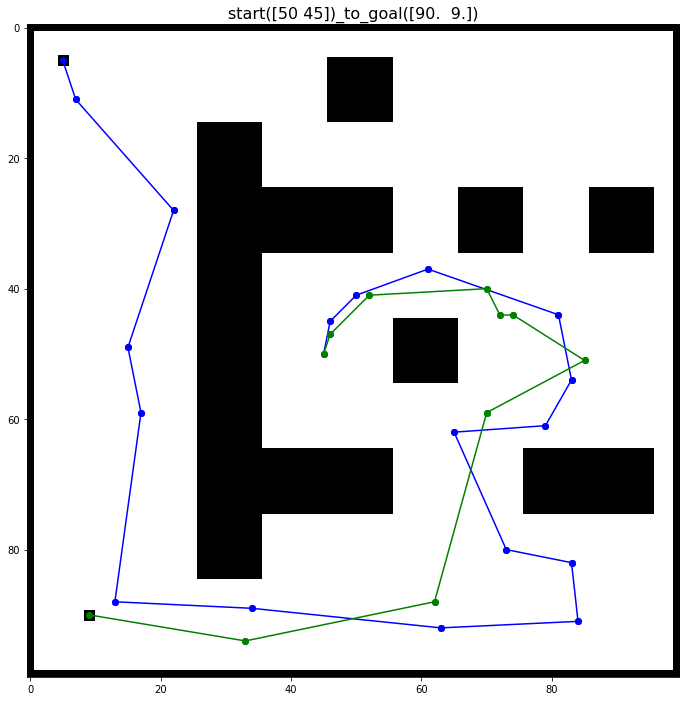

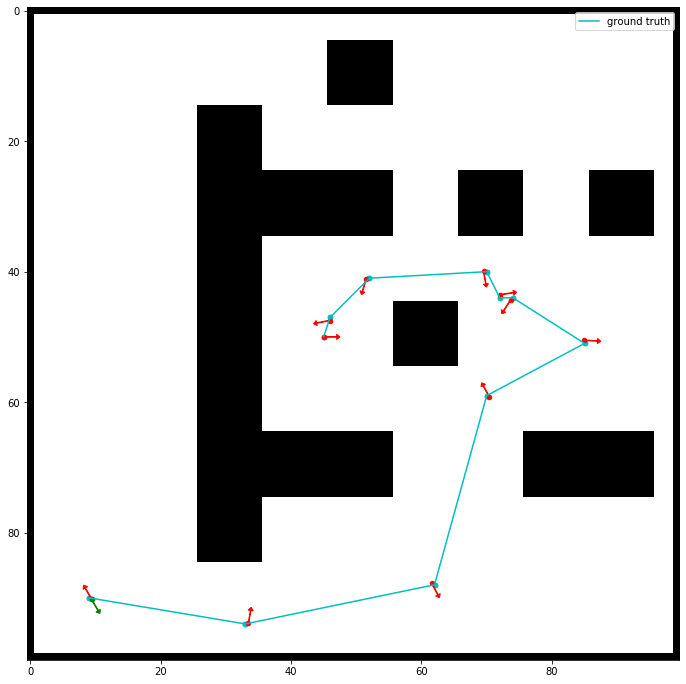

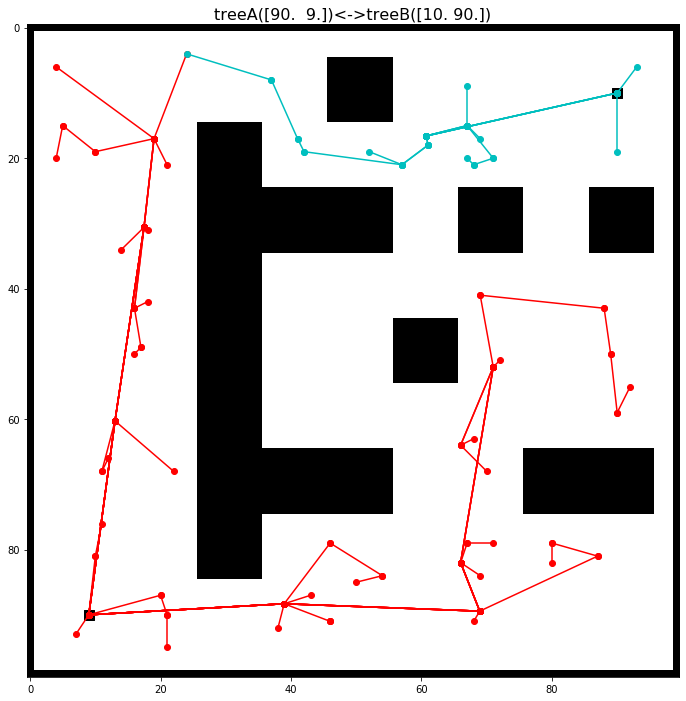

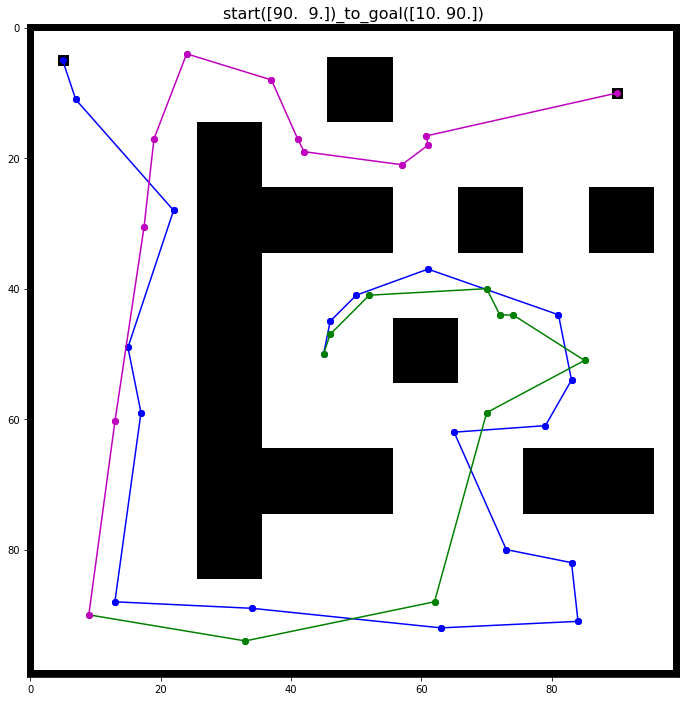

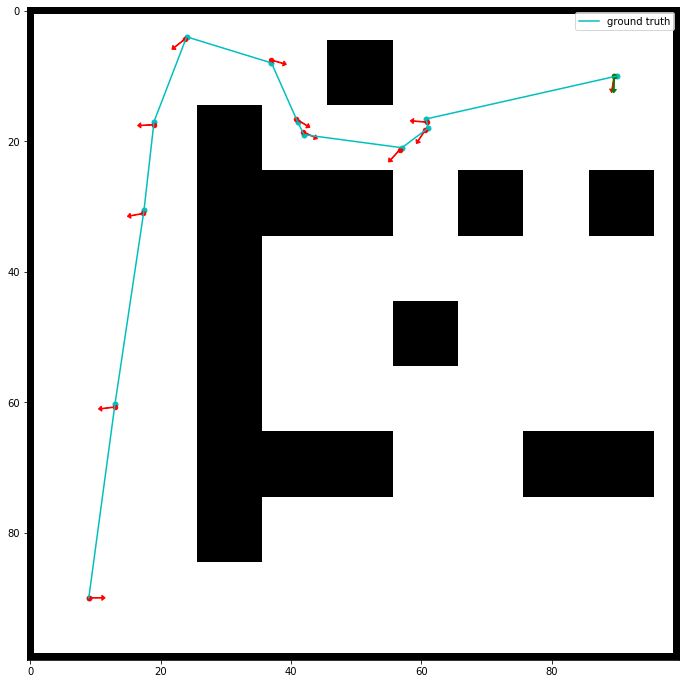

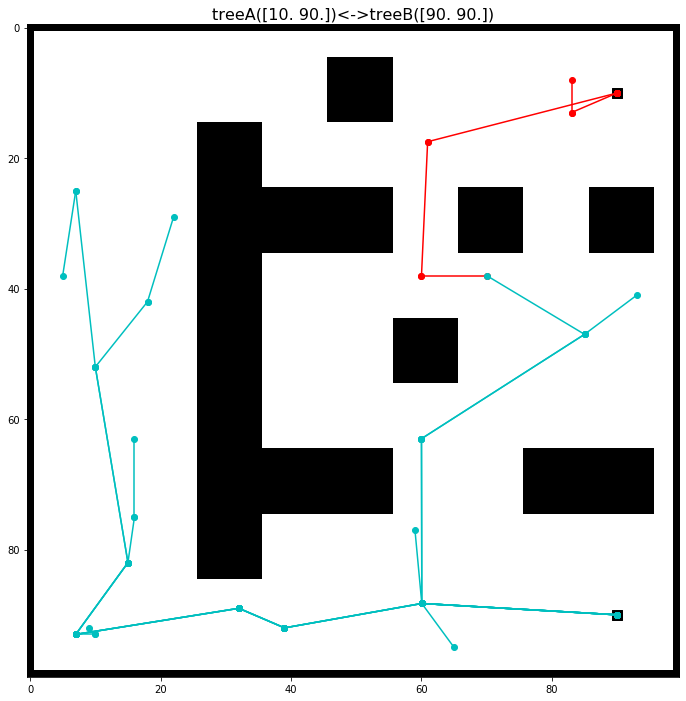

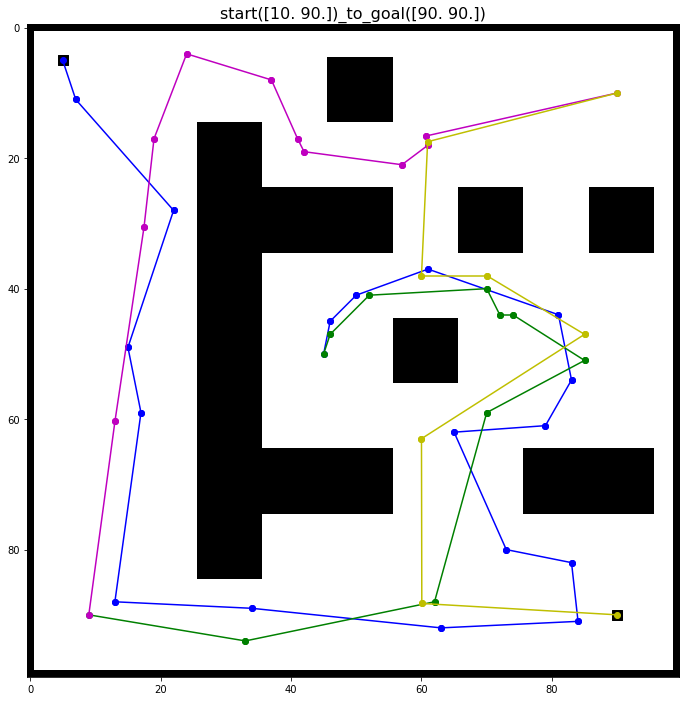

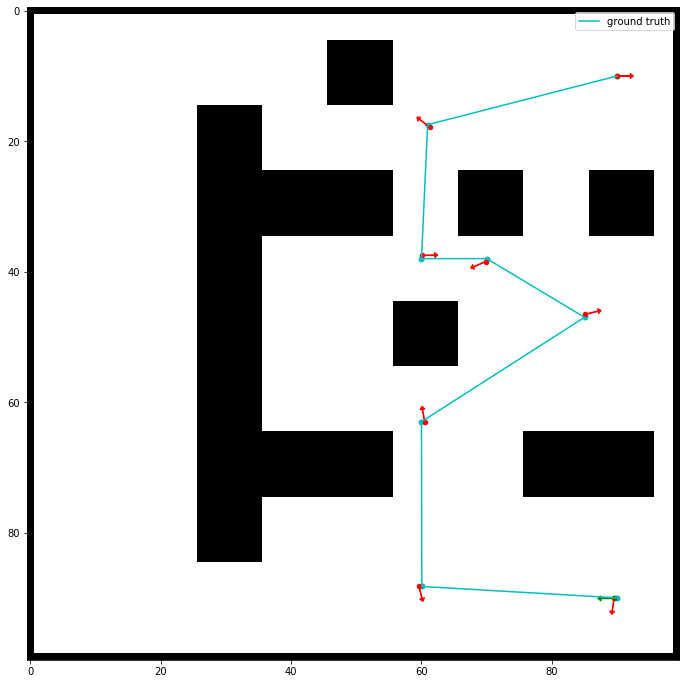

In [8]:
if __name__ == '__main__':
    try:
        # Read pgm map file
        grid = read_pgm('sim_map.pgm')
        grid = np.where(grid==255, 0, 1)
        
        # Waypoints (including scenic viewpoints and orientations)
        waypoints = [(5., 5.),
                     (50, 45, 0), # waypoint: (Y, X, theta)
                     (90, 9, np.pi/3.),
                     (10, 90, np.pi/2.),
                     (90, 90, np.pi)]
        stops = len(waypoints)
        retries = 10
        iteration = 0
        planner = RRTPlanner(grid, delta=30.0, eps=0.05, N=500, plot=True)
        for w in range(stops-1):
            while not planner.path and iteration < retries:
                print("Iteration {}".format(iteration))
                planner.find_path(waypoints[w], waypoints[w+1])
                iteration += 1
            if not planner.path:
                print("Path planning FAILED!")
                break
            # Motion planning
            motion_planner = MotionPlanner(planner, objective=w+1, plot=False)
            motion_planner.run()
            motion_planner.plot_path(motion_planner.history, motion_planner.ground_truth, motion_planner.views)
            planner.path = []
            iteration = 0
    except KeyboardInterrupt:
        exit(0)

In [10]:
!python3 --version

Python 3.6.9
